# Проект 1: Прогнозирование активности пользователей приложения

**Цель проекта:**

Спрогнозировать, как изменится активность пользователей в течение ближайшего месяца, чтобы подготовить инфраструктуру к возможным пиковым нагрузкам и предотвратить сбои в работе приложения. Прогноз позволит оптимизировать ресурсы и обеспечить стабильную работу приложения в будущем.

## Задачи:

1.  **Выбор основной метрики:**
    *   Определить ключевую метрику, наилучшим образом характеризующую общую активность пользователей приложения.
    *   Обосновать выбор данной метрики.

2.  **Определение временного разрешения:**
    *   Определить подходящее временное разрешение (например, почасовое, ежедневное) для анализа и прогнозирования данных.
    *   Обосновать выбор выбранного временного разрешения.

3.  **Определение регрессоров:**
    *   Выявить и обосновать дополнительные регрессоры, которые могут повлиять на прогнозируемую метрику.
    *   Включить эти факторы в модель прогнозирования.

4.  **Построение и оценка прогнозных моделей (с использованием Orbit):**
    *   Выбрать несколько подходящих моделей прогнозирования временных рядов из библиотеки `Orbit`.
    *   Построить несколько моделей прогнозирования на основе имеющихся исторических данных и выбранных регрессоров.
    *   Провести оценку качества каждой модели.

5.  **Анализ данных для бэктестинга:**
    *   Проанализировать объем доступных данных для оценки возможности проведения бэктестинга модели.

6.  **Выбор лучшей модели и анализ ограничений:**
    *   Сравнить результаты нескольких моделей, используя выбранные метрики качества.
    *   Выбрать лучшую модель на основе метрик валидации и обосновать этот выбор.
    *   Проанализировать ограничения выбранной модели и указать их в отчете.

In [1]:
import orbit 
from orbit.models import DLT 
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для визуализации предсказаний
from orbit.eda import eda_plot

#общее
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #для визуализации MCMC

## Метрика

В качестве основной метрики для прогнозирования выбрано **общее количество действий пользователя в приложении**, которое представляет собой сумму лайков, просмотров и отправленных сообщений.  Этот показатель должен отражать нагрузку на серверы, так как учитывает интенсивность взаимодействия пользователей с приложением.

Данные агрегируются **почасово**, что позволяет более детально отслеживать динамику нагрузки на серверы в течение дня и выявлять пиковые часы.

**DAU** (Daily Active Users) - **ковариата**. DAU - это дневная метрика, которая используется как дополнительный фактор, влияющий на почасовую активность пользователей. DAU помогает модели учесть общую активность в течение дня при прогнозировании почасовых значений.

## Временное разрешение

Ежедневное временное разрешение детально отражает динамику активности пользователей, а также позволяет улавливать сезонныне и недельные тренды, однако не подойдет для выявления пиковых нагрузок, которые, предположительно, приводят в подвисаниям в приложении. **Почасовые данные** помогут увидеть динамику изменения нагрузки в течение дня и выделить пиковые часы. 

## Регрессоры

В модель прогнозирования включены следующие дополнительные регрессоры:

*   **День недели:** для учета недельной сезонности.
*   **Рекламная кампания/флешмоб (с 2024-10-10 по 2024-10-17):** для учета влияния рекламной кампании на активность пользователей.
*   **Аномалия (2024-10-19):** для учета резкого падения активности в этот день.


In [49]:
#параметры подключения к бд
connection = {'host': 'https://clickhouse.example',
            'database':'database',
            'user':'user',
            'password':'password'
            }

q_feed_actions = """
SELECT
    toDate(toDateTime(fa.time)) AS date,
    count(fa.action) AS feed_actions_count,
    toDayOfWeek(toDateTime(fa.time)) AS day_of_week
FROM
    {db}.feed_actions fa
WHERE toDateTime(fa.time) >= '2024-08-31'
  AND toDateTime(fa.time) <= '2024-11-30'
GROUP BY date, day_of_week
ORDER BY date
"""

q_message_actions = """
SELECT
    toDate(toDateTime(ma.time)) AS date,
    count(ma.user_id) AS message_actions_count
FROM
    {db}.message_actions ma
WHERE toDateTime(ma.time) >= '2024-08-31'
  AND toDateTime(ma.time) <= '2024-11-30'
GROUP BY date
ORDER BY date
"""

q_dau = """
SELECT
    toDate(toDateTime(time)) AS date,
    count(DISTINCT user_id) AS dau
FROM (
    SELECT time, user_id
    FROM {db}.feed_actions
    UNION ALL
    SELECT time, user_id
    FROM {db}.message_actions
) AS combined_actions
WHERE toDateTime(time) >= '2024-08-31'
  AND toDateTime(time) <= '2024-11-30'
GROUP BY date
ORDER BY date
"""

In [50]:
df_feed_actions = ph.read_clickhouse(query=q_feed_actions, connection=connection)
df_message_actions = ph.read_clickhouse(query=q_message_actions, connection=connection)
df_dau = ph.read_clickhouse(query=q_dau, connection=connection)

In [51]:
# Преобразование и 'date' в datetime для корректного объединения

df_feed_actions['date'] = pd.to_datetime(df_feed_actions['date'])
df_message_actions['date'] = pd.to_datetime(df_message_actions['date'])
df_dau['date'] = pd.to_datetime(df_dau['date'])

# Объединение данных по дате и времени
merged_data = pd.merge(df_feed_actions, df_message_actions, on=['date'], how='left')

# Елси нет нет данных, замена на 0
merged_data['message_actions_count'] = merged_data['message_actions_count'].fillna(0)

# total_actions
merged_data['total_actions'] = merged_data['feed_actions_count'] + merged_data['message_actions_count']

# Удаление избыточных столбцов
merged_data.drop(["feed_actions_count", "message_actions_count"], axis=1, inplace=True)

# добовим HAU по 'hour' и 'date'
merged_data = pd.merge(merged_data, df_dau, on=['date'], how='left')

# Создание флага флешмоба
merged_data['flashmob'] = ((merged_data['date'] >= '2024-10-10') & (merged_data['date'] <= '2024-10-17')).astype(int)

# Создание флага аномалии
merged_data['anomaly'] = (merged_data['date'] == '2024-10-19').astype(int)


print(merged_data.head())

        date  day_of_week  total_actions   dau  flashmob  anomaly
0 2024-08-31            6          12389  1045         0        0
1 2024-09-01            7          88481  2494         0        0
2 2024-09-02            1         139381  3396         0        0
3 2024-09-03            2         155693  4011         0        0
4 2024-09-04            3         221856  4997         0        0


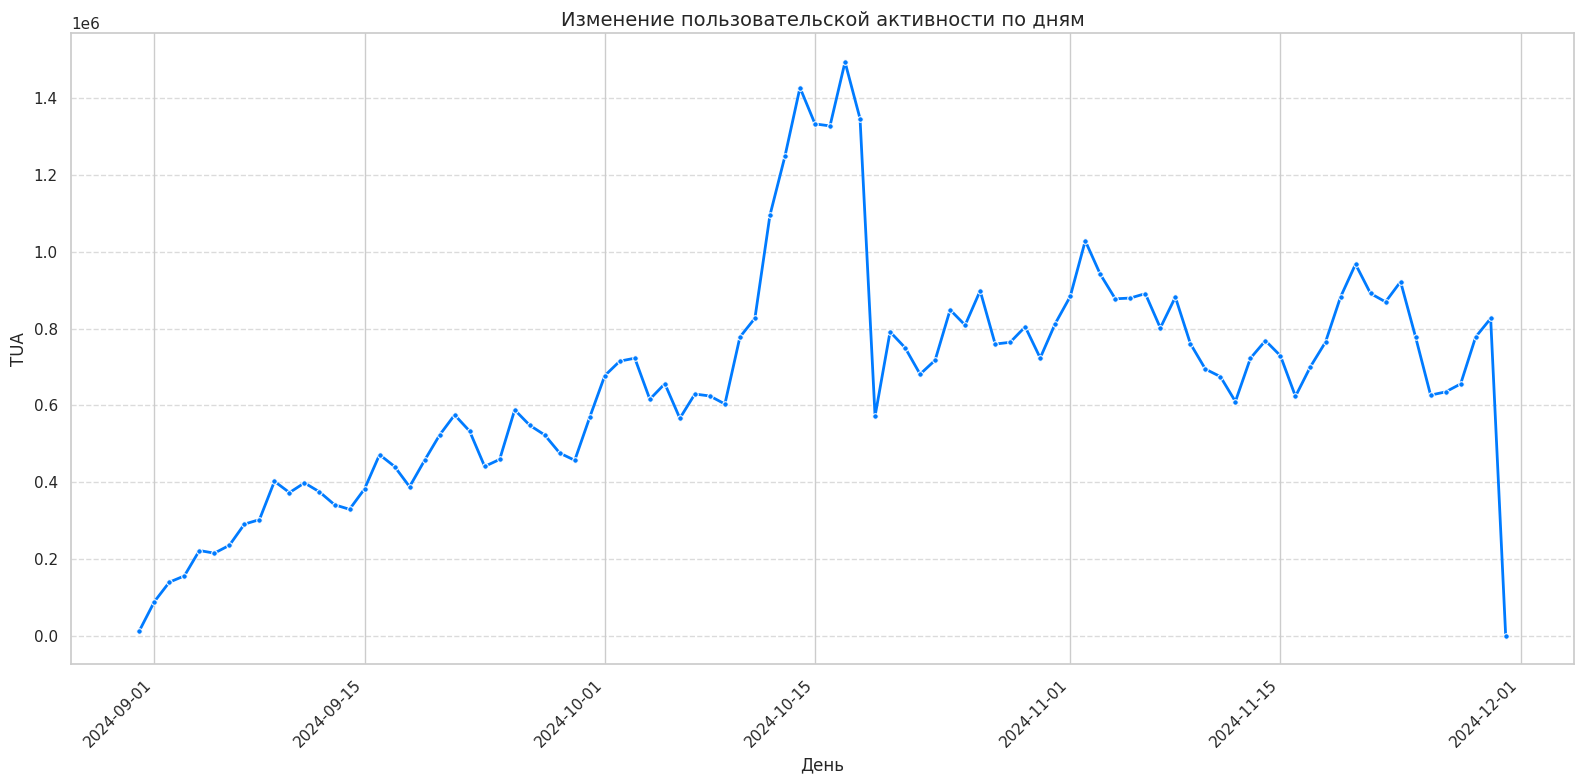

In [33]:
#как менялась активность пользователей по дням
sns.set(rc={'figure.figsize':(16,8)}, style="whitegrid")

plt.xticks(rotation=45, ha="right")
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12)

plt.title("Изменение пользовательской активности по дням", fontsize=14)
plt.xlabel("День", fontsize=12)
plt.ylabel("TUA", fontsize=12)

sns.lineplot(x="date", y="total_actions", data=merged_data, marker='o', markersize=4, linestyle='-', linewidth=2, color='#007bff') 

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

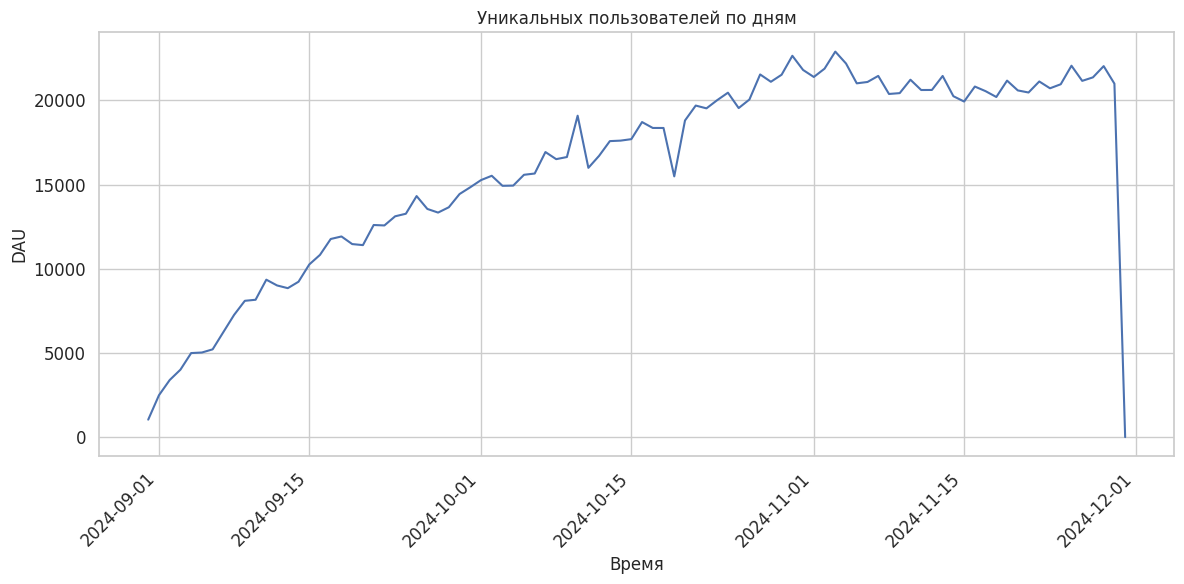

In [34]:
# График DAU
plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="dau", data=merged_data)
plt.title("Уникальных пользователей по дням")
plt.xlabel("Время")
plt.ylabel("DAU")
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

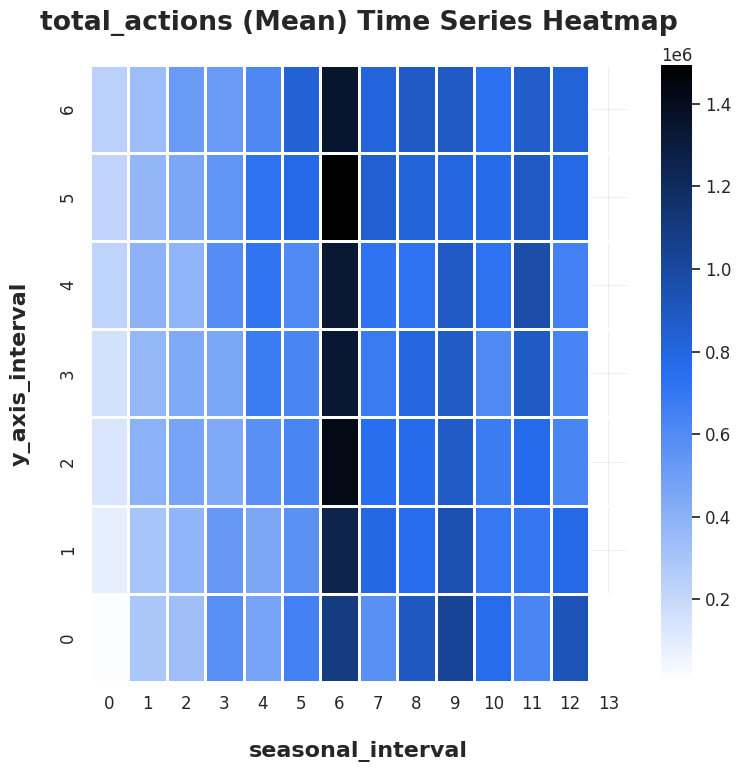

In [35]:
#тепловая карта - выделяет более темным цветом наиболее активные дни
_ = eda_plot.ts_heatmap(df=merged_data, date_col="date", value_col="total_actions", seasonal_interval=7, normalization=False)

In [36]:
# выбор регрессоров 

merged_data.drop("date", axis=1).corr(method="spearman")

,day_of_week,total_actions,dau,flashmob,anomaly
day_of_week,1.000000,-0.001191,-0.066124,-0.003669,0.103691
total_actions,-0.001191,1.000000,0.761694,0.427062,-0.057237
dau,-0.066124,0.761694,1.000000,0.000000,-0.041447
flashmob,-0.003669,0.427062,0.000000,1.000000,-0.032351
anomaly,0.103691,-0.057237,-0.041447,-0.032351,1.000000


## Анализ корреляций и выбор регрессоров

Перед построением модели был проведен анализ корреляций между различными признаками, чтобы оценить их взаимосвязь и принять решения о включении/исключении их из модели. Для этого был использован коэффициент корреляции Спирмена.

**Основные выводы:**

*   **`total_actions` и `dau` (0.762):** Наблюдается сильная положительная корреляция. Чем больше уникальных пользователей активно в день (`dau`), тем выше общая активность (`total_actions`). Это является весомым аргументом в пользу включения `dau` в модель.

*   **`total_actions` и `flashmob` (0.427):** Существует умеренная положительная корреляция. Флешмоб, похоже, способствует увеличению общей активности, поэтому этот признак стоит включить в модель.

*   **`total_actions` и `anomaly` (-0.057):** Обнаружена низкая отрицательная корреляция. Аномалия, вероятно, не оказывает существенного влияния на общую активность и даже может немного понижать ее, поэтому этот признак стоит исключить из модели.

*   **`total_actions` и `day_of_week` (-0.001):** Обнаружена очень низкая отрицательная корреляция, что может указывать на практически полное отсутствие связи между днем недели и общей активностью. Этот признак не будет информативным, и его стоит исключить из модели.

**Решения по регрессорам:**

*   **Исключение `anomaly`:** На основе низкой отрицательной корреляции с `total_actions`, признак аномалии был исключен из модели.
*   **Исключение `day_of_week`:** На основе очень низкой корреляции с `total_actions`, признак был исключен из модели.

**Стандартизация данных:**

Перед построением модели регрессии будет проведена стандартизация данных (z-score нормализация) для признаков `total_actions`, `dau` и `flashmob` по следующим причинам:

*   **Приведение к единому масштабу:** Стандартизация приводит все признаки к единому масштабу со средним значением 0 и стандартным отклонением 1. Это важно, когда признаки имеют разные единицы измерения или диапазоны значений, как в нашем случае.

*  **Улучшение сходимости:** Многие алгоритмы машинного обучения, особенно те, которые основаны на градиентном спуске, работают лучше, когда признаки стандартизированы. Стандартизация также позволяет избежать доминирования одних переменных над другими.

*   **Корректная интерпретация:** Стандартизация может упростить интерпретацию коэффициентов регрессии.

In [52]:
#стандартизация

total_actions_mean = merged_data.total_actions.mean()
total_actions_std = merged_data.total_actions.std()

dau_mean = merged_data.dau.mean()
dau_std = merged_data.dau.std()

merged_data["ta_stand"] = (merged_data.total_actions - total_actions_mean) / total_actions_std
merged_data["dau_stand"] = (merged_data.dau - dau_mean) / dau_std

merged_data.head()

,date,day_of_week,total_actions,dau,flashmob,anomaly,ta_stand,dau_stand
0,2024-08-31,6,12389,1045,0,0,-2.215651,-2.572539
1,2024-09-01,7,88481,2494,0,0,-1.958313,-2.323111
2,2024-09-02,1,139381,3396,0,0,-1.786173,-2.167843
3,2024-09-03,2,155693,4011,0,0,-1.731007,-2.061979
4,2024-09-04,3,221856,4997,0,0,-1.507249,-1.892251


## Разделение данных для обучения и бектестинга

Для построения и оценки модели прогнозирования временных рядов, данные были разделены на три части: обучающую выборку, тестовую выборку и данные для бектестинга.

**Обучающая выборка (Training Set):**

*   **Назначение:** Используется для обучения модели, то есть для настройки ее параметров и выявления закономерностей в данных.
*   **Период:** `2024-08-31` - `2024-10-31`.
*   **Описание:** На этих данных модель учится предсказывать значения `total_actions` на основе признаков `dau` и `flashmob`.

**Бектестинг:**

*   **Назначение:** Проводится для более надежной оценки качества модели. Модель тестируется на исторических данных с использованием скользящего окна, чтобы имитировать реальные условия использования.
*  **Метод:** Обученная модель на периоде `2024-08-31` - `2024-10-31` используется для прогноза значений `total_actions` на периоде `2024-11-01` - `2024-11-30`.
*   **Описание:** Бектестинг имитирует процесс использования модели на исторических данных, для оценки её стабильности и предсказательной силы. Этот процесс дает более надежную оценку, нежели обычное тестирование на отдельной тестовой выборке.

**Важные принципы разделения данных:**

*   **Временная последовательность:** Данные разделяются в строгой временной последовательности, то есть обучающие данные должны предшествовать тестовым и данным для бектестинга. Это необходимо для того, чтобы модель обучалась на данных из прошлого и корректно прогнозировала будущее.
*  **Избежание "подглядывания" в будущее:** Обучающая выборка не должна содержать информацию из тестовой или бектестовой выборок, чтобы избежать смещения в оценке модели.
*   **Репрезентативность:** Данные должны быть достаточно репрезентативными, чтобы отражать общие закономерности, а не какие-то специфические аномалии.

In [53]:
# Разделение данных
train_dat = merged_data.query("date < '2024-11-01'").copy()
test_dat = merged_data.query("date >= '2024-11-01'").copy()

In [54]:
train_dat.head()

,date,day_of_week,total_actions,dau,flashmob,anomaly,ta_stand,dau_stand
0,2024-08-31,6,12389,1045,0,0,-2.215651,-2.572539
1,2024-09-01,7,88481,2494,0,0,-1.958313,-2.323111
2,2024-09-02,1,139381,3396,0,0,-1.786173,-2.167843
3,2024-09-03,2,155693,4011,0,0,-1.731007,-2.061979
4,2024-09-04,3,221856,4997,0,0,-1.507249,-1.892251


## Выбор модели для прогнозирования временных рядов: сравнение линейного и лог-линейного трендов

Для прогнозирования значений `total_actions` (общего количества действий) будут рассмотрены модели с линейным и лог-линейным трендами, а также варианты с использованием регрессоров (`dau` - количество активных пользователей за день, и `flashmob` - бинарный флаг, указывающий на наличие флешмоба). Такой подход позволит оценить как вклад временной составляющей, так и влияние дополнительных признаков на динамику целевой переменной.

**Рассматриваемые варианты:**

1.  **Тренд без регрессоров:**

    *   **Линейный тренд:**
        *   Предполагает, что `total_actions` изменяется с постоянной скоростью с течением времени.
        *   Будет использован как базовая модель для сравнения с более сложными моделями.
    *   **Лог-линейный тренд:**
        *   Предполагает, что `total_actions` изменяется с постоянной скоростью в процентах с течением времени.

2.  **Тренд с одним регрессором:**

    *   **Линейный тренд + `dau`:**
        *   Позволит оценить, как `dau` (количество активных пользователей за день) влияет на `total_actions` при наличии линейного тренда.
    *   **Лог-линейный тренд + `dau`:**
       *  Позволит оценить, как `dau` влияет на `total_actions` при наличии лог-линейного тренда.
    *   **Линейный тренд + `flashmob`:**
        *   Позволит оценить, как наличие или отсутствие флешмоба влияет на `total_actions` при наличии линейного тренда.
    *   **Лог-линейный тренд + `flashmob`:**
        *  Позволит оценить, как наличие или отсутствие флешмоба влияет на `total_actions` при наличии лог-линейного тренда.
       * Позволит оценить влияние каждого регрессора в отдельности.

3.  **Тренд с двумя регрессорами:**

    *   **Линейный тренд + `hourly_unique_users` + `flashmob`:**
        *   Позволит оценить совместное влияние `dau` и `flashmob` на `total_actions` при наличии линейного тренда.
    *    **Лог-линейный тренд + `dau` + `flashmob`:**
        *   Позволит оценить совместное влияние `dau` и `flashmob` на `total_actions` при наличии лог-линейного тренда.
        *   Позволит оценить совместное влияние всех регрессоров на `total_actions`.


**Обоснование выбора DLT:**

Модель LGT (Local Global Trend) не подходит для использования со стандартизованными данными, так как она работает только с положительными значениями. Модель DLT (Dynamic Linear Trend), в отличие от LGT, допускает отрицательные значения, что делает ее более подходящей для работы с стандартизованными данными, которые могут содержать отрицательные значения.

** Обоснование выбора `stan-mcmc`:**

Метод `stan-mcmc` (Markov Chain Monte Carlo) выбран для оценки параметров модели по следующим причинам:

*   **Точность:** `stan-mcmc` предоставляет распределение вероятностей параметров, а не точечные оценки, что повышает точность и позволяет оценить их неопределенность.
*   **Прогностические интервалы:**  Позволяет формировать прогностические интервалы, что отражает неопределенность прогнозов.
*   **Надежность:** `stan-mcmc` обеспечивает надежную оценку параметров, особенно в случаях, когда распределение вероятностей не является нормальным.
*   **Стабильность:**  `stan-mcmc` использует алгоритмы, которые обеспечивают сходимость цепей Маркова, что гарантирует стабильность результатов.
*  **Временные ряды:** Хорошо справляется с моделированием сложной структуры временных рядов (тренд, сезонность).

**Причины отказа от `stan-map`:**

*   **Низкая точность:** `stan-map` показал недостаточную точность при прогнозировании (не представлено в работе).
*   **Отсутствие интервалов:** `stan-map` не предоставляет интервалов прогнозов.

In [55]:
linear = DLT(response_col="ta_stand", 
            date_col="date",
            seasonality=7,
            estimator="stan-mcmc", 
            global_trend_option="linear",
            num_warmup = 10000, 
            num_sample=10000)

linear_1r = DLT(response_col="ta_stand", 
            date_col="date",
            seasonality=7,
            estimator="stan-mcmc", 
            global_trend_option="linear",
            regressor_col=["dau_stand"], regressor_sign=["+"],
            num_warmup = 10000, 
            num_sample=10000)

linear_2r = DLT(response_col="ta_stand", 
            date_col="date",
            seasonality=7,
            estimator="stan-mcmc", 
            global_trend_option="linear",
            regressor_col=["dau_stand","flashmob"], regressor_sign=["+","+"],
            num_warmup = 10000, 
            num_sample=10000)

loglinear = DLT(response_col="ta_stand", 
            date_col="date",
            seasonality=7,
            estimator="stan-mcmc", 
            global_trend_option="loglinear",
            num_warmup = 10000, 
            num_sample=10000)

loglinear_1r = DLT(response_col="ta_stand", 
            date_col="date",
            seasonality=7,
            estimator="stan-mcmc", 
            global_trend_option="loglinear",
            regressor_col=["dau_stand"], regressor_sign=["+"],
            num_warmup = 10000, 
            num_sample=10000)

loglinear_2r = DLT(response_col="ta_stand", 
            date_col="date",
            seasonality=7,
            estimator="stan-mcmc", 
            global_trend_option="loglinear",
            regressor_col=["dau_stand","flashmob"], regressor_sign=["+","+"],
            num_warmup = 10000, 
            num_sample=10000)

model_list = [linear, loglinear, linear_1r, loglinear_1r, linear_2r, loglinear_2r]

In [56]:
#обучение

for model in model_list:
    
    model.fit(train_dat)

2025-01-27 23:29:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:29:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:30:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:30:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:30:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:30:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [57]:
#df с будущими датами
future = model_list[0].make_future_df(periods = 30)

#прогноз для моделей без регрессоров
prediction_1 = model_list[0].predict(future)
prediction_2 = model_list[1].predict(future)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

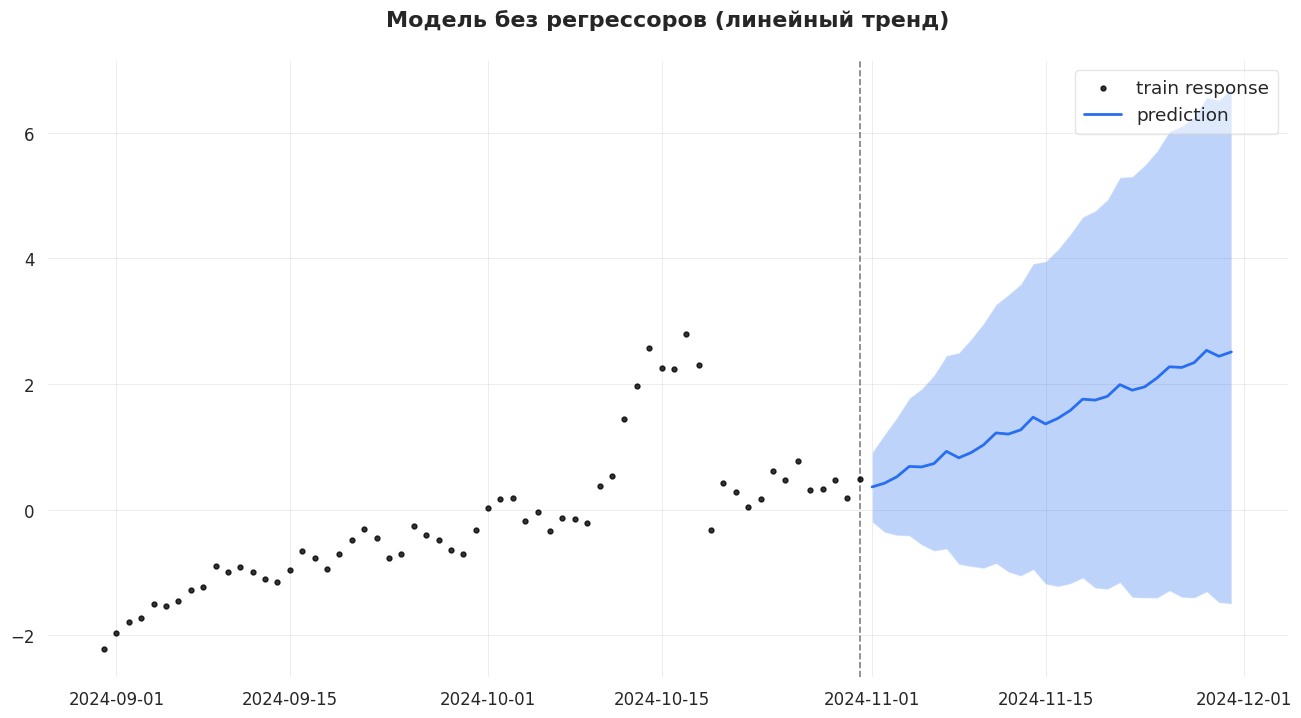

In [58]:
_ = plot_predicted_data(train_dat, prediction_1, "date", 'ta_stand', title='Модель без регрессоров (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

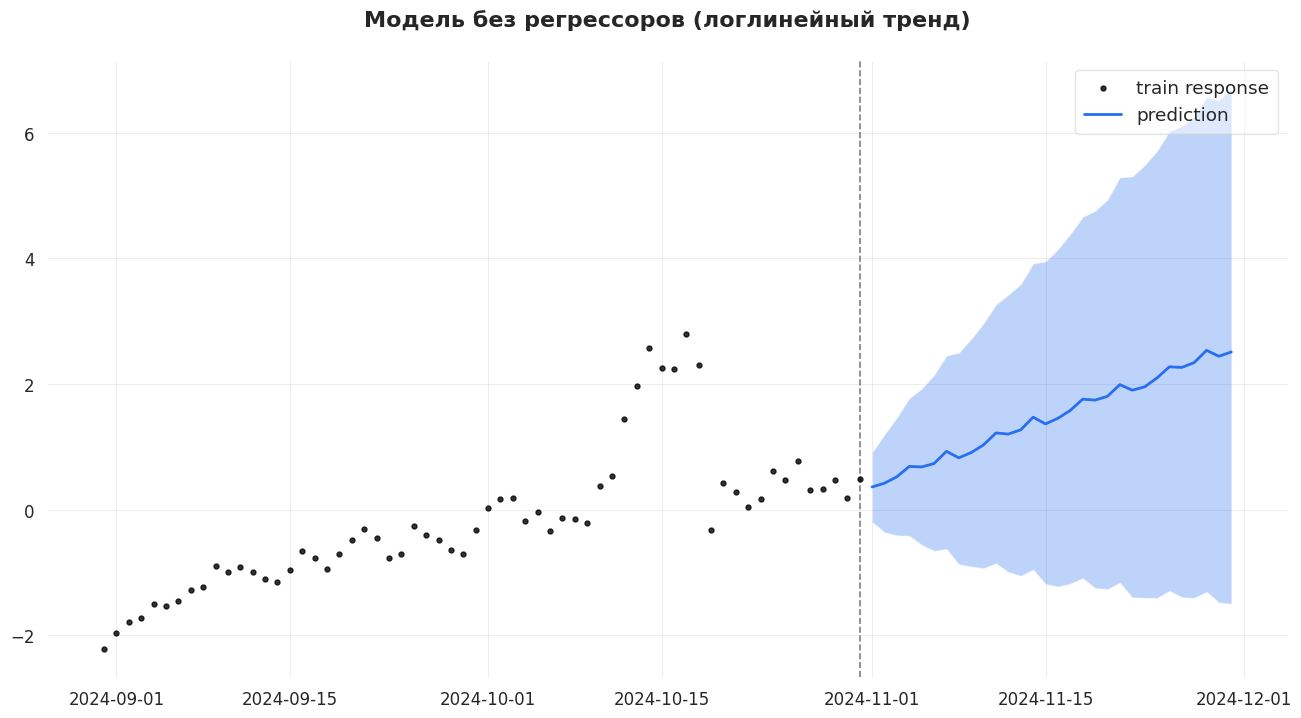

In [59]:
_ = plot_predicted_data(train_dat, prediction_1, "date", 'ta_stand', title='Модель без регрессоров (логлинейный тренд)')

In [60]:
#future df для моделей с dau дополнить предсказаниями dau

#обучение для dau
dau_model = DLT(response_col = "dau_stand",
            date_col="date",
            estimator="stan-mcmc",
            global_trend_option="linear",
            num_warmup = 10000, 
            num_sample=10000)

dau_model.fit(train_dat)

2025-01-27 23:34:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [61]:
#прогноз регрессора dau
dau_pred = dau_model.predict(future)

In [62]:
future["dau_stand"] = dau_pred.prediction
future.head()

,date,dau_stand
0,2024-11-01,1.150510
1,2024-11-02,1.210688
2,2024-11-03,1.271514
3,2024-11-04,1.335933
4,2024-11-05,1.399647


In [63]:
model_list[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,dau_stand,Positive,0.769649,0.231775,1.336433,1.0,0.0


In [64]:
#прогноз моделей с регрессором вau

prediction_3 = model_list[2].predict(future)
prediction_4 = model_list[3].predict(future)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

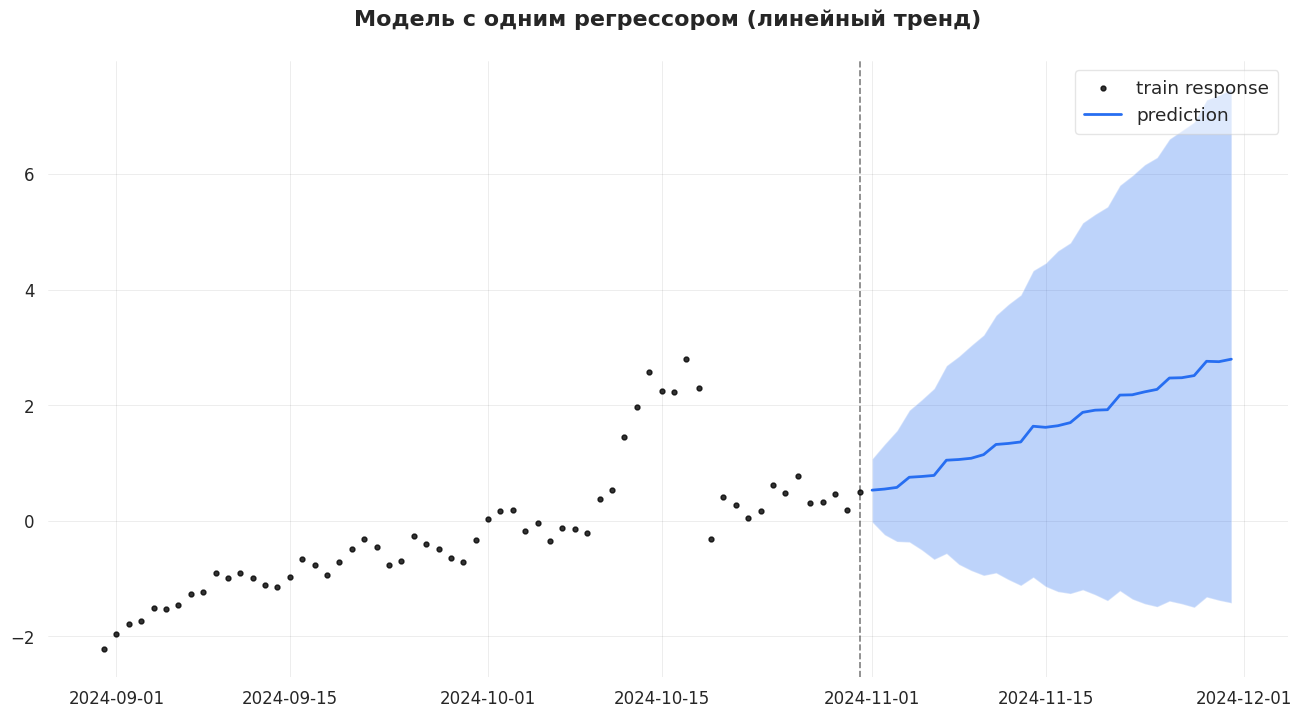

In [65]:
_ = plot_predicted_data(train_dat, prediction_3, "date", 'ta_stand', title='Модель с одним регрессором (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

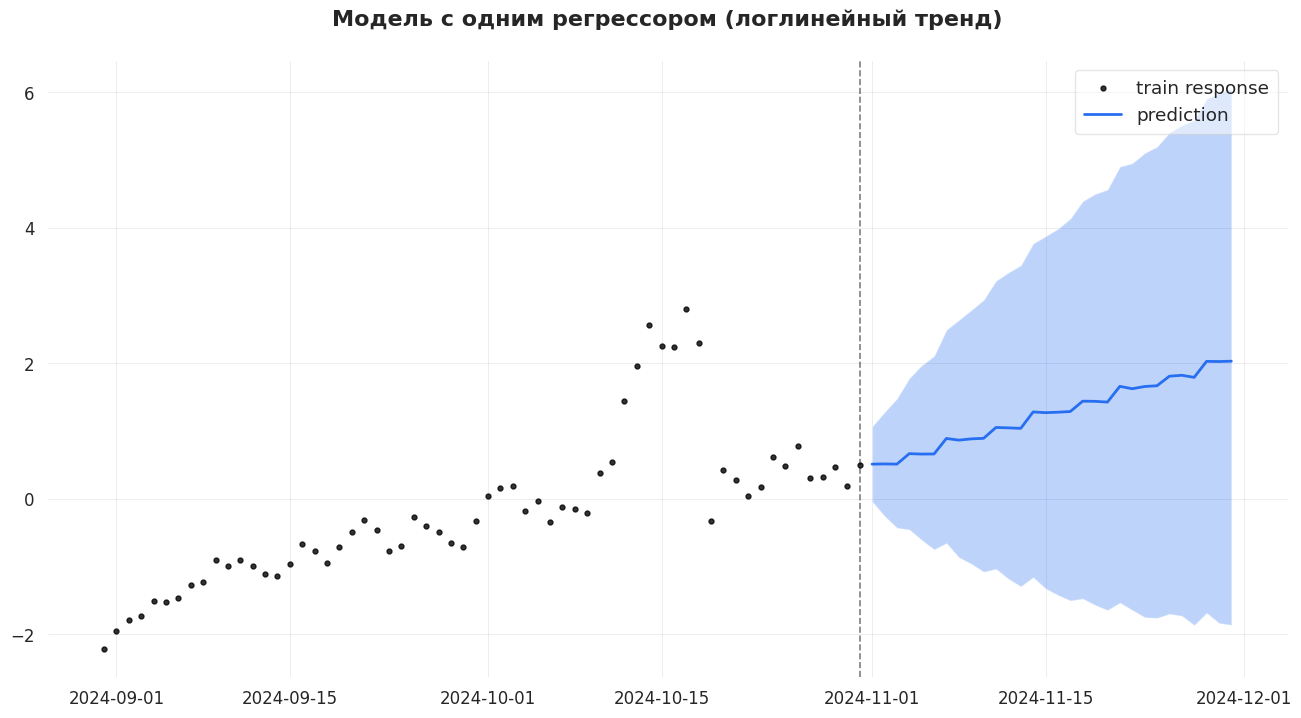

In [66]:
_ = plot_predicted_data(train_dat, prediction_4, "date", 'ta_stand', title='Модель с одним регрессором (логлинейный тренд)')

In [67]:
#добавляем второй регрессор - бинаруную переменную flashmob

future["flashmob"] = 0
future.head()

,date,dau_stand,flashmob
0,2024-11-01,1.150510,0
1,2024-11-02,1.210688,0
2,2024-11-03,1.271514,0
3,2024-11-04,1.335933,0
4,2024-11-05,1.399647,0


In [68]:
#прогноз моделей с двумя регрессорами

prediction_5 = model_list[4].predict(future)
prediction_6 = model_list[5].predict(future)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

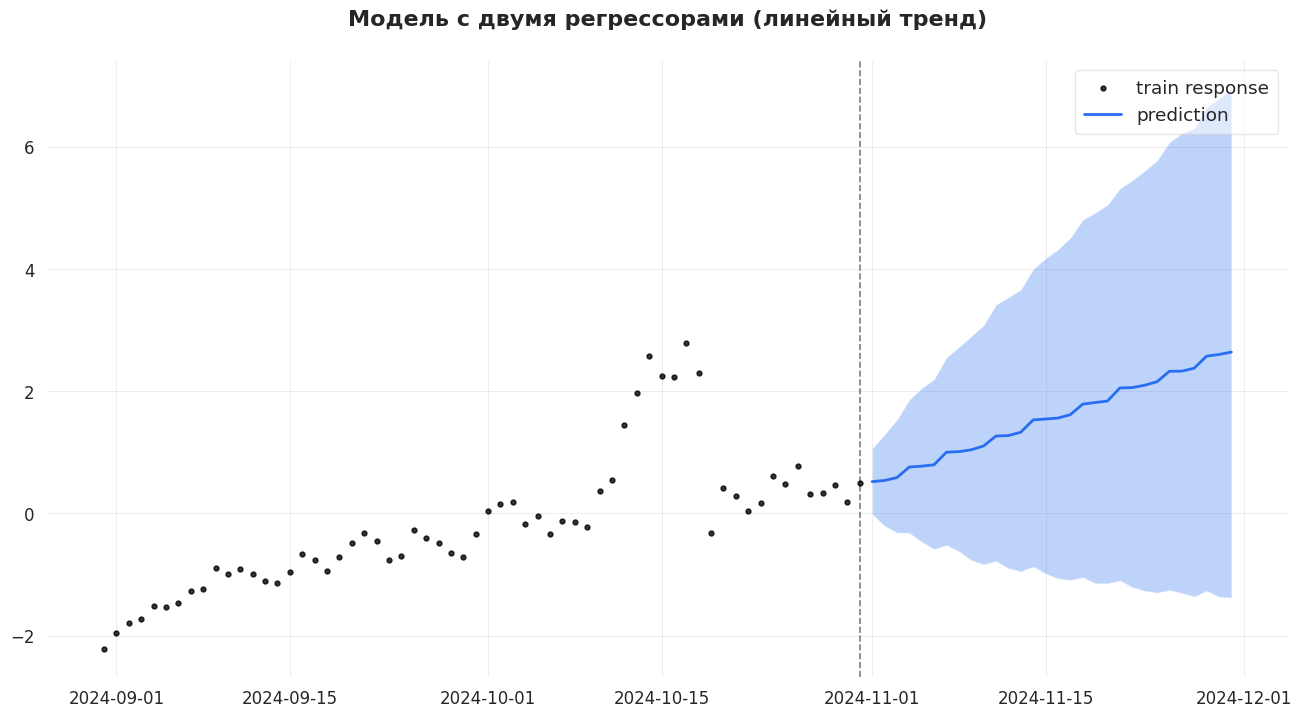

In [69]:
_ = plot_predicted_data(train_dat, prediction_5, "date", 'ta_stand', title='Модель с двумя регрессорами (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

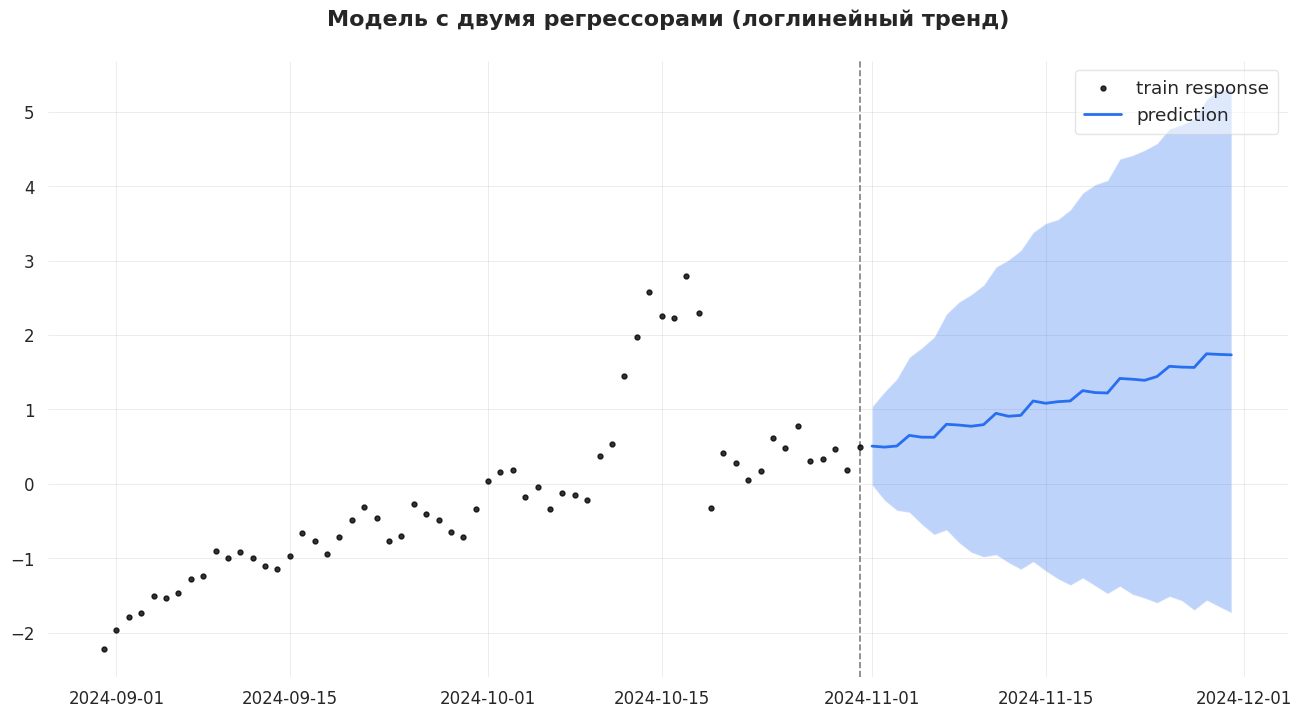

In [70]:
_ = plot_predicted_data(train_dat, prediction_6, "date", 'ta_stand', title='Модель с двумя регрессорами (логлинейный тренд)')

In [72]:
from orbit.diagnostics.backtest import BackTester

In [74]:
backtesting_list = []

for model in model_list:

    backtester = BackTester(
        model=model, 
        df=train_dat, #датафрейм для обучения
        min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение
        incremental_len=7, #на сколько происходит прирост тренировочных данных
        forecast_len=30, #горизонт пронозирования
        window_type="rolling" #тип окошка
    )

    backtester.fit_predict()
    
    
    backtesting_list.append(backtester)

2025-01-27 23:55:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:56:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:57:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:57:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:57:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:57:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:57:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:58:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:58:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:58:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:58:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:58:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:59:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:59:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:59:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:59:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-27 23:59:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [99]:
# выводим метрики и примеры прогнозов для каждой модели
for i, backtester in enumerate(backtesting_list):
    print(f"----- Модель {i+1} -----")

    # Метрики качества
    scores_df = backtester.score()
    print("Метрики качества:")

    best_metric = None
    best_value = float('inf')  # или -inf если ищем наибольшее значение (например, r2)

    for index, row in scores_df.iterrows():
        metric = row['metric_name']
        value = row['metric_values']

        if isinstance(value, (int, float)):
            print(f"  {metric}: {value:.4f}")


----- Модель 1 -----
Метрики качества:
  smape: 1.2149
  wmape: 0.9451
  mape: 2.1349
  mse: 0.8712
  mae: 0.6493
  rmsse: 1.7699
----- Модель 2 -----
Метрики качества:
  smape: 1.0307
  wmape: 0.9507
  mape: 2.1863
  mse: 1.0549
  mae: 0.6531
  rmsse: 1.9476
----- Модель 3 -----
Метрики качества:
  smape: 1.2042
  wmape: 0.8680
  mape: 1.6517
  mse: 0.7982
  mae: 0.5963
  rmsse: 1.6942
----- Модель 4 -----
Метрики качества:
  smape: 1.0031
  wmape: 0.7324
  mape: 1.1608
  mse: 0.7181
  mae: 0.5031
  rmsse: 1.6070
----- Модель 5 -----
Метрики качества:
  smape: 1.2049
  wmape: 1.0415
  mape: 2.8939
  mse: 0.8791
  mae: 0.7155
  rmsse: 1.7780
----- Модель 6 -----
Метрики качества:
  smape: 0.8981
  wmape: 0.6483
  mape: 1.3116
  mse: 0.4615
  mae: 0.4454
  rmsse: 1.2882


In [108]:
# бектестер для модели 6
backtester_model_6 = backtesting_list[5]

# df с предсказаниями для модели 6
predicted_df_model_6 = backtester_model_6.get_predicted_df()

print(predicted_df_model_6.head())

        date    actual  prediction_5  prediction  prediction_95  \
0 2024-08-31 -2.215651     -2.377091   -2.214611      -2.050496   
1 2024-09-01 -1.958313     -2.192624   -1.959584      -1.741612   
2 2024-09-02 -1.786173     -2.010603   -1.786045      -1.568059   
3 2024-09-03 -1.731007     -1.959349   -1.733254      -1.516687   
4 2024-09-04 -1.507249     -1.739646   -1.509324      -1.294562   

   training_data  split_key  
0           True          0  
1           True          0  
2           True          0  
3           True          0  
4           True          0  


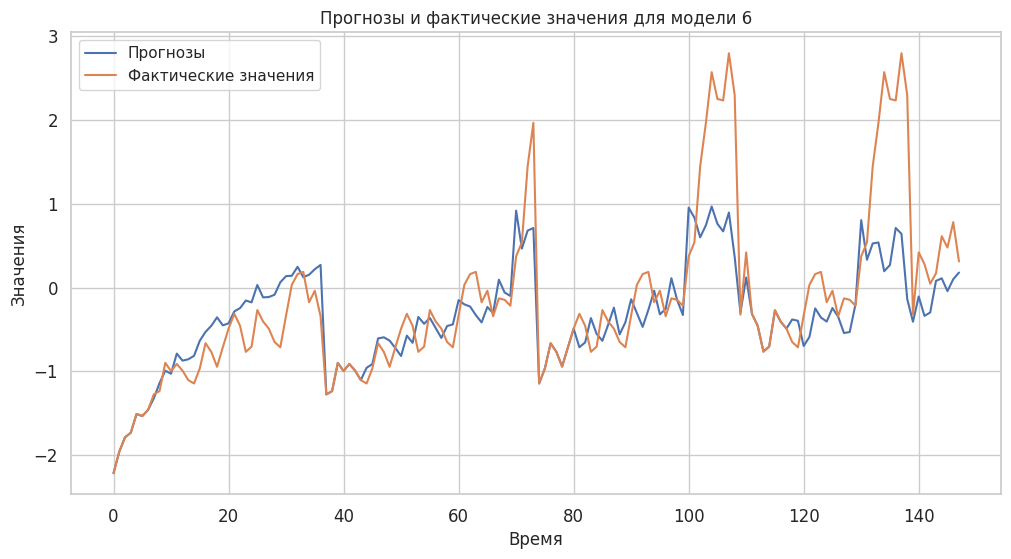

In [106]:
#Визуализация
plt.figure(figsize=(12, 6))
plt.plot(predicted_df_model_6.index, predicted_df_model_6['prediction'], label='Прогнозы')
plt.plot(predicted_df_model_6.index, predicted_df_model_6['actual'], label='Фактические значения')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.title('Прогнозы и фактические значения для модели 6')
plt.legend()
plt.grid(True)
plt.show()

## Общий вывод:

1. **Сравнение моделей:**
   - После бектестинга моделей (линейные и логлинейные), получены следующие результаты:
     - **smape:** Модель 6 (0.8981) - наименьшее значение.
     - **wmape:** Модель 6 (0.6483) - наименьшее значение.
     - **mape:** Модель 4 (1.1608) - наименьшее значение.
     - **mse:**  Модель 6 (0.4615) - наименьшее значение.
     - **mae:** Модель 6 (0.4454) - наименьшее значение.
     - **rmsse:** Модель 6 (1.2882) - наименьшее значение.


2. **Выбор лучшей модели:**
   - Модель 6 (логлинейная с глобальным трендом и двумя регрессорами: `dau_stand`, `flashmob`) показывает лучшие результаты по большинству метрик. Она наиболее точно прогнозирует активность пользователей.

3. **Интерпретация:**
   - Модель 6 демонстрирует наименьшие ошибки и процентную ошибку (smape), что указывает на высокую точность прогноза.

4. **Соответствие целям проекта:**
   - Модель 6 лучше всего подходит для прогнозирования активности пользователей на месяц вперёд, что позволит подготовить инфраструктуру к нагрузкам и обеспечить стабильную работу приложения.


## Ограничения логлинейной модели DLT Stan-MCMC с двумя регрессорами

Модель, которую мы рассматриваем, представляет собой логлинейный тренд с двумя регрессорами, реализованный с использованием DLT (Dynamic Linear Trend) подхода и оцененный с помощью Stan-MCMC. Такая модель, хоть и является мощным инструментом для анализа временных рядов, имеет ряд ограничений, которые важно учитывать:

### 1. Ограничения, связанные с логлинейным трендом:

*   **Предположение о монотонном росте/снижении:** Логлинейный тренд предполагает, что базовая тенденция роста или снижения со временем будет монотонной. Это может быть неадекватно, если тренд имеет значительные изменения направления или колебания. 
*   **Чувствительность к выбросам:** При преобразовании данных в логарифмическую шкалу, выбросы могут оказать непропорциональное влияние на оценку тренда. Перед применением модели необходимо провести анализ на наличие аномальных значений и, при необходимости, обработать их.
*   **Не подходит для нулевых и отрицательных значений:** Логарифмическое преобразование не определено для нулевых и отрицательных значений. 

### 2. Ограничения, связанные с регрессорами:

*   **Зависимость от качества регрессоров:** Модель с регрессорами полностью зависит от качества этих регрессоров. Если регрессоры не объясняют значительную часть изменчивости временного ряда или если они имеют низкое качество, то и прогнозы модели будут плохими.
*   **Ограниченные возможности для учета нелинейных зависимостей:** Включение регрессоров в линейном виде может не уловить нелинейные зависимости между временным рядом и регрессорами. Это приводит к тому, что часть изменчивости данных будет пропущена. В этом случае, можно рассмотреть нелинейные модели.
*   **Мультиколлинеарность:** Если регрессоры сильно коррелируют между собой (мультиколлинеарность), это может привести к нестабильным оценкам коэффициентов регрессии. В результате, интерпретация влияния каждого регрессора на временной ряд становится затруднительной. 
*  **Неопределенность будущих значений регрессоров:** Модель с регрессорами зависит от наличия будущих значений этих регрессоров. Если для построения прогноза, вы используете будущие значения регрессоров, то их точность будет напрямую влиять на точность прогнозов.

### 3. Ограничения, связанные с DLT и Stan-MCMC:

*   **Вычислительная сложность Stan-MCMC:** Использование Stan-MCMC может быть ресурсоемким в вычислительном плане, особенно для больших наборов данных или сложных моделей. Это может ограничить применение модели при наличии большого количества данных или когда требуется быстрый расчет.
*   **Зависимость от адекватности априорных распределений:** MCMC методы требуют задания априорных распределений для параметров модели. Неадекватные априорные распределения могут повлиять на качество оценки параметров и прогнозов.
*   **Предположение о стационарности параметров:** Модель DLT подразумевает, что параметры (например, уровень, наклон, коэффициенты регрессии) изменяются плавно во времени. Если параметры меняются резко или не стационарны, то это может ограничить эффективность модели.